In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import diffxpy as de
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)

In [4]:
adata = sc.read('./../../data/processed/adata_annotated.h5ad')
adata_ = sc.read('./../../data/processed/data_norm.h5ad')
adata_.obs = adata.obs.copy()

In [6]:
#Load saved diffxpy results
import pickle 
with open('../../results/diffxpy_louvain_correct_standard_2021.pickle', 'rb') as f:
    de_results_louvain = pickle.load(f)

# Look at the results

In [7]:
de_results_listofdicts = []
for i, item in enumerate(de_results_louvain):
    de_results_dict = {
        'louvain': de_results_louvain[i]    
    }
    if i == 0:
        de_results_dict['pairtest'] = 'BL Ctrl vs BL Stress'
    elif i == 1:
        de_results_dict['pairtest'] = 'ELS Ctrl vs ELS Stress'
    elif i == 2:
        de_results_dict['pairtest'] = 'BL Stress vs ELS Stress'
    elif i == 3:
        de_results_dict['pairtest'] = 'BL Ctrl vs ELS Ctrl'
    de_results_listofdicts.append(de_results_dict)

In [8]:
def de_postprocessing(de_results_listofdicts, adata):
    de_post = []
    
    for de_results_dict in de_results_listofdicts:
        for clust_type in ['louvain']:
            for clust in de_results_dict[clust_type]:
                if clust in adata.obs[clust_type].cat.categories:
                    tmp = de_results_dict[clust_type][clust].summary()
                    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
                    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]
    
                    #Sort values by q-value
                    tmp.sort_values(by='qval', ascending=True, inplace=True)
        
                    de_post.append({'clust': clust, 
                              'clust_type': clust_type, 
                              'de_post': tmp.copy(), 
                              'de_raw': de_results_dict[clust_type][clust],
                              'pairtest': de_results_dict['pairtest']
                             })
            
    de_post_df = pd.DataFrame(de_post)
    del de_post
    
    de_post_df['ndeg_mean0.5'] = ''
    de_post_df['ndeg_mean1'] = ''
    de_post_df['ndeg'] = ''
    
    for index, row in de_post_df.T.iteritems():
        test = row['pairtest']
        if test == 'BL Ctrl vs BL Stress':
            mask = ((adata.obs['baseline']=='BL'))
            condition_key = 'adult_stress'
            condition_ctrl = 'Ctrl'
            condition_test = 'Stress'
        elif test == 'ELS Ctrl vs ELS Stress':
            mask = ((adata.obs['baseline'] == 'ELS'))
            condition_key = 'adult_stress'
            condition_ctrl = 'Ctrl'
            condition_test = 'Stress'
        elif test == 'BL Ctrl vs ELS Ctrl':
            mask = ((adata.obs['adult_stress'] == 'Ctrl'))
            condition_key = 'baseline'
            condition_ctrl = 'BL'
            condition_test = 'ELS'
        elif test == 'BL Stress vs ELS Stress':
            mask = ((adata.obs['adult_stress'] == 'Stress'))
            condition_key = 'baseline'
            condition_ctrl = 'BL'
            condition_test = 'ELS'

        adata_test = adata_[mask]
        expr_dict_stress = {}
        expr_dict_ctrl = {}
        clust = row['clust']
        
        expr_ctrl = np.mean(adata_test[
            (adata_test.obs[condition_key]==condition_ctrl) 
            & (adata_test.obs['louvain'] == clust)
        ].X, axis=0)
        
        expr_stress = np.mean(adata_test[
            (adata_test.obs[condition_key]==condition_test) 
            & (adata_test.obs['louvain'] == clust)
        ].X, axis=0)
        
        for i, gene in enumerate(adata_test.var.index):
            expr_dict_stress[gene] = expr_stress[i]
            expr_dict_ctrl[gene] = expr_ctrl[i]

        de_post_df.iloc[index]['de_post']['mean_ctrl'] = [
            expr_dict_ctrl[gene] for gene in row['de_post']['gene'].values
        ]
        
        de_post_df.iloc[index]['de_post']['mean_test'] = [
            expr_dict_stress[gene] for gene in row['de_post']['gene'].values
        ]

        de_post_df.iloc[index]['ndeg_mean0.5'] = (
            de_post_df
            .iloc[index]['de_post']
            .loc[
                (row['de_post']['qval']<0.05)
                & (
                    (row['de_post']['mean_test']>0.5)
                    | (row['de_post']['mean_ctrl']>0.5)
                )
            ]
            .shape[0]
        )
        
        de_post_df.iloc[index]['ndeg_mean1'] = (
            de_post_df
            .iloc[index]['de_post']
            .loc[
                (row['de_post']['qval']<0.05) 
                & (
                    (row['de_post']['mean_test']>1)
                    | (row['de_post']['mean_ctrl']>1)
                )
            ]
            .shape[0]
        )
        
        de_post_df.iloc[index]['ndeg'] = (
            de_post_df
            .iloc[index]['de_post']
            .loc[(row['de_post']['qval']<0.05)]
            .shape[0]
        )

    return de_post_df

In [9]:
de_post_df = de_postprocessing(de_results_listofdicts, adata)

In [11]:
listofdicts = []

mean_thr = 0.5
log2fc_thr = 0.5
for i, cluster in enumerate((de_post_df['clust'].unique())):
    de_post_df_clust = de_post_df[de_post_df['clust']==cluster]
    set_genes = set()
    for test in de_post_df_clust.pairtest.unique():
        
        tmp = de_post_df_clust.iloc[
            np.where((de_post_df_clust['pairtest']==test)
            )[0][0]
        ]
        
        set_genes |= set(tmp['de_post']['gene'][(
            (tmp['de_post']['qval']<0.05)
            & (
                (tmp['de_post']['mean_test']>mean_thr)
                | (tmp['de_post']['mean_ctrl']>mean_thr)
            )
            & (np.abs(tmp['de_post']['log2fc'])>log2fc_thr)
        )]) 
            
    listofdicts.append({
        'clust': cluster,
        'genes': set_genes
    })
    
genes_sets = pd.DataFrame(listofdicts)

In [12]:
genes_sets

clust  \
0                       GABA   
1              Cajal-Retzius   
2   Granule Neuroblasts (DG)   
3                       NPCs   
4                  DG Glut 1   
5                  DG Glut 2   
6                 CA3 Glut 1   
7                 CA3 Glut 2   
8                 CA3 Glut 3   
9                 CA1 Glut 1   
10                CA1 Glut 2   
11                CA1 Glut 3   
12                   Astro 1   
13                   Astro 2   
14                   Astro 3   
15                      OPCs   
16                       COP   
17                      MFOL   
18                      NFOL   
19          Oligodendrocytes   
20               Microglia 1   
21               Microglia 2   
22               Macrophages   
23                 Ependymal   
24                 Pericytes   
25               Endothelial   
26             Endothelial 2   
27                 Meningeal   
28                  Vascular   
29                 DG Glut 3   
30            Choroid Plexus   

                                                genes  
0   {Rab11a, Lrp11, Dync1i2, Sec61g, Tusc2, Pcnp, ...  
1   {Cetn3, mt-Nd4, Sdhb, Cd47, Syndig1l, Sec61g, ...  
2   {Rps27, Tceal9, Dync1i2, Npc2, Clta, Anapc5, E...  
3   {Zfp706, Arglu1, Slbp, Sec61g, Ndufab1, Snu13,...  
4   {Saraf, Lrp11, Ubald1, Smap2, Arpp19, Psip1, H...  
5   {Ppp3r1, Ncdn, Hsp90b1, Gm47283, Ank2, R3hdm1,...  
6   {Tmem191c, Eif4g3, Smap2, Sec61g, Psip1, Snu13...  
7   {Tmem191c, Eif4g3, A230050P20Rik, Psip1, Scn2b...  
8   {Rps27, mt-Nd4, Mrpl20, Crym, Ndufs3, Ndufv2, ...  
9   {Kidins220, Psmd7, Mrpl14, Smap2, Scn2b, Snu13...  
10  {Serpini1, Cdc40, Gm47283, Dlg4, Galnt17, Ank2...  
11  {Eif5a, Dlgap1, Tpi1, Wbp11, Cox6a1, Atp1a3, S...  
12  {Csrp1, Saraf, Tubb2a, Junb, Mfsd2a, Hspa2, Tm...  
13  {Cetn3, Rps27, Zfp706, Rps12, Hspa2, Zfp36l1, ...  
14  {Emc7, Actb, Appl2, Npc2, Grk3, Lfng, Pcyt2, m...  
15  {Ier2, Junb, Ncan, Mrfap1, Srsf3, Set, BC00556...  
16  {Sox8, Actb, Sgk1, Sec61g, Lhfpl3, Snrpg, Snu1...  
17  {Tceal9, Itch, Atp1b3, Usf2, Psip1, Snu13, Ttc...  
18  {Cetn3, Actb, Sox8, Itch, Psmd7, Ppfibp2, Smap...  
19  {mt-Nd4, Ddx5, St13, Nudt4, Sgk1, Psip1, Snu13...  
20  {Tuba1b, Ogfrl1, Selenos, Ndufa4, Alox5ap, Heb...  
21  {Saraf, Wnk1, Nfe2l2, Eif5a, C1qb, Slc38a2, H2...  
22  {Zfp36l1, Sec61g, Ncoa4, Snrpg, Snu13, Clic1, ...  
23  {Dync2li1, Fhad1, Psip1, Churc1, Tpi1, 1700088...  
24  {Rps27, Ifitm3, Junb, Sod3, Ptp4a3, Serf2, Myl...  
25  {Ly6a, Slc16a1, Kctd10, Jam2, Zfp36l1, Paqr5, ...  
26  {Zfp36l1, Eif5a, Psmd7, Abcb1a, Higd1a, Clic1,...  
27  {Tceal9, Olfml3, Zfp36l1, Actb, Sec61g, Snrpg,...  
28  {Cetn3, Actb, Sec61g, Snrpg, Snu13, Atp6v0c, T...  
29  {Mical2, Grm5, Srcin1, Timm44, Tmem108, Ssbp4,...  
30  {Cyb561, Car12, mt-Nd4, Saraf, Krtcap2, Pgrmc1...

In [13]:
expr_listofdicts = []
for clust in genes_sets.clust.unique():
    for condition in adata.obs.condition.unique():
        expr = np.mean(
            adata_[
                (adata_.obs.condition==condition) 
                & (adata_.obs['louvain'] == clust)
            ].X, axis=0
        )
        for i, gene in enumerate(genes_sets.loc[genes_sets['clust'] == clust]['genes'].values[0]):
            expr_listofdicts.append({
                'clust': clust,
                'gene': gene,
                'condition': condition,
                'expr': expr[adata_.var_names == gene][0]
            })

In [14]:
df = pd.DataFrame(expr_listofdicts)

In [15]:
df

clust     gene   condition      expr
0                GABA   Rab11a  ELS_Stress  0.618742
1                GABA    Lrp11  ELS_Stress  0.608565
2                GABA  Dync1i2  ELS_Stress  0.642779
3                GABA   Sec61g  ELS_Stress  0.837367
4                GABA    Tusc2  ELS_Stress  0.659231
...               ...      ...         ...       ...
48959  Choroid Plexus    Tmed2    ELS_Ctrl  0.532845
48960  Choroid Plexus     Nsg2    ELS_Ctrl  0.717346
48961  Choroid Plexus   Zfp106    ELS_Ctrl  0.511255
48962  Choroid Plexus    Cntn1    ELS_Ctrl  1.039661
48963  Choroid Plexus   Malat1    ELS_Ctrl  2.217644

[48964 rows x 4 columns]

In [16]:
def pattern_scores(df):
    listofdicts = []
    
    for clust in df.clust.unique():
        df_clust = df.loc[df.clust == clust]
        print(clust)
        
        for gene in df_clust.gene.unique():
            df_clust_gene = df_clust.loc[df_clust.gene == gene]
            
            scores_dict = {
                'gene': gene,
                'clust': clust,
            }
            
            expr_array = [
                df_clust_gene.loc[df_clust_gene['condition'] == 'BL_Ctrl']['expr'].values[0],
                df_clust_gene.loc[df_clust_gene['condition'] == 'BL_Stress']['expr'].values[0],
                df_clust_gene.loc[df_clust_gene['condition'] == 'ELS_Ctrl']['expr'].values[0],
                df_clust_gene.loc[df_clust_gene['condition'] == 'ELS_Stress']['expr'].values[0],
            ]
            
            expr_array /= np.max(np.abs(expr_array))
            scores_dict['BL_Ctrl_expr'] = expr_array[0]
            scores_dict['BL_Stress_expr'] = expr_array[1]
            scores_dict['ELS_Ctrl_expr'] = expr_array[2]
            scores_dict['ELS_Stress_expr'] = expr_array[3]
            #scores_dict['weight'] = (
            #    np.sum(adata_[adata_.obs.louvain == clust, adata_.var_names == gene].X != 0)
            #    / adata_[adata_.obs.louvain == clust].shape[0]
            #)
            
            delta_bl = (
                expr_array[1]
                - expr_array[0]
            )
            
            delta_els = (
               expr_array[3]
                - expr_array[2]
            )
            
            mean_bl = np.mean([expr_array[1], expr_array[0]])
            mean_els = np.mean([expr_array[3], expr_array[2]])
            ctrl_diff = np.abs(
                expr_array[0]
                - expr_array[2]
            )
            
            #scores_dict['mean_bl'] = mean_bl
            #scores_dict['mean_els'] = mean_els
            #scores_dict['delta_bl'] = delta_bl
            #scores_dict['delta_els'] = delta_els
            #scores_dict['ctrl_diff'] = ctrl_diff
            
            scores_dict['chronic'] = (
                delta_bl 
                - np.abs(delta_els)
                - np.abs(
                    expr_array[1]
                    - mean_els
                )
            )
            
            scores_dict['chronic_2'] = (
                - delta_bl 
                - np.abs(delta_els) 
                - np.abs(
                    expr_array[1]
                    - mean_els
                )
            )
            
            scores_dict['inverted'] = (
                - delta_bl
                + delta_els
                - ctrl_diff
            )
            
            scores_dict['inverted_2'] = (
                delta_bl
                - delta_els
                - ctrl_diff
            )
            
            scores_dict['primed'] = (
                delta_els
                - np.abs(delta_bl)
                - np.abs(
                    expr_array[2]
                    - mean_bl
                )
            )
            
            scores_dict['primed_2'] = (
                - delta_els
                - np.abs(delta_bl)
                - np.abs(
                    expr_array[2]
                    - mean_bl
                )
            )
            
            scores_dict['blunted'] = (
                delta_bl
                - np.abs(delta_els)
                - np.abs(
                    expr_array[0]
                    - mean_els
                )
            )
            
            scores_dict['blunted_2'] = (
                - delta_bl
                - np.abs(delta_els)
                - np.abs(
                    expr_array[0]
                    - mean_els
                )
            )
            
            listofdicts.append(scores_dict)
    
    results = pd.DataFrame(listofdicts)
    return results

In [17]:
res = pattern_scores(df)

GABA
Cajal-Retzius
Granule Neuroblasts (DG)
NPCs
DG Glut 1
DG Glut 2
CA3 Glut 1
CA3 Glut 2
CA3 Glut 3
CA1 Glut 1
CA1 Glut 2
CA1 Glut 3
Astro 1
Astro 2
Astro 3
OPCs
COP
MFOL
NFOL
Oligodendrocytes
Microglia 1
Microglia 2
Macrophages
Ependymal
Pericytes
Endothelial
Endothelial 2
Meningeal
Vascular
DG Glut 3
Choroid Plexus


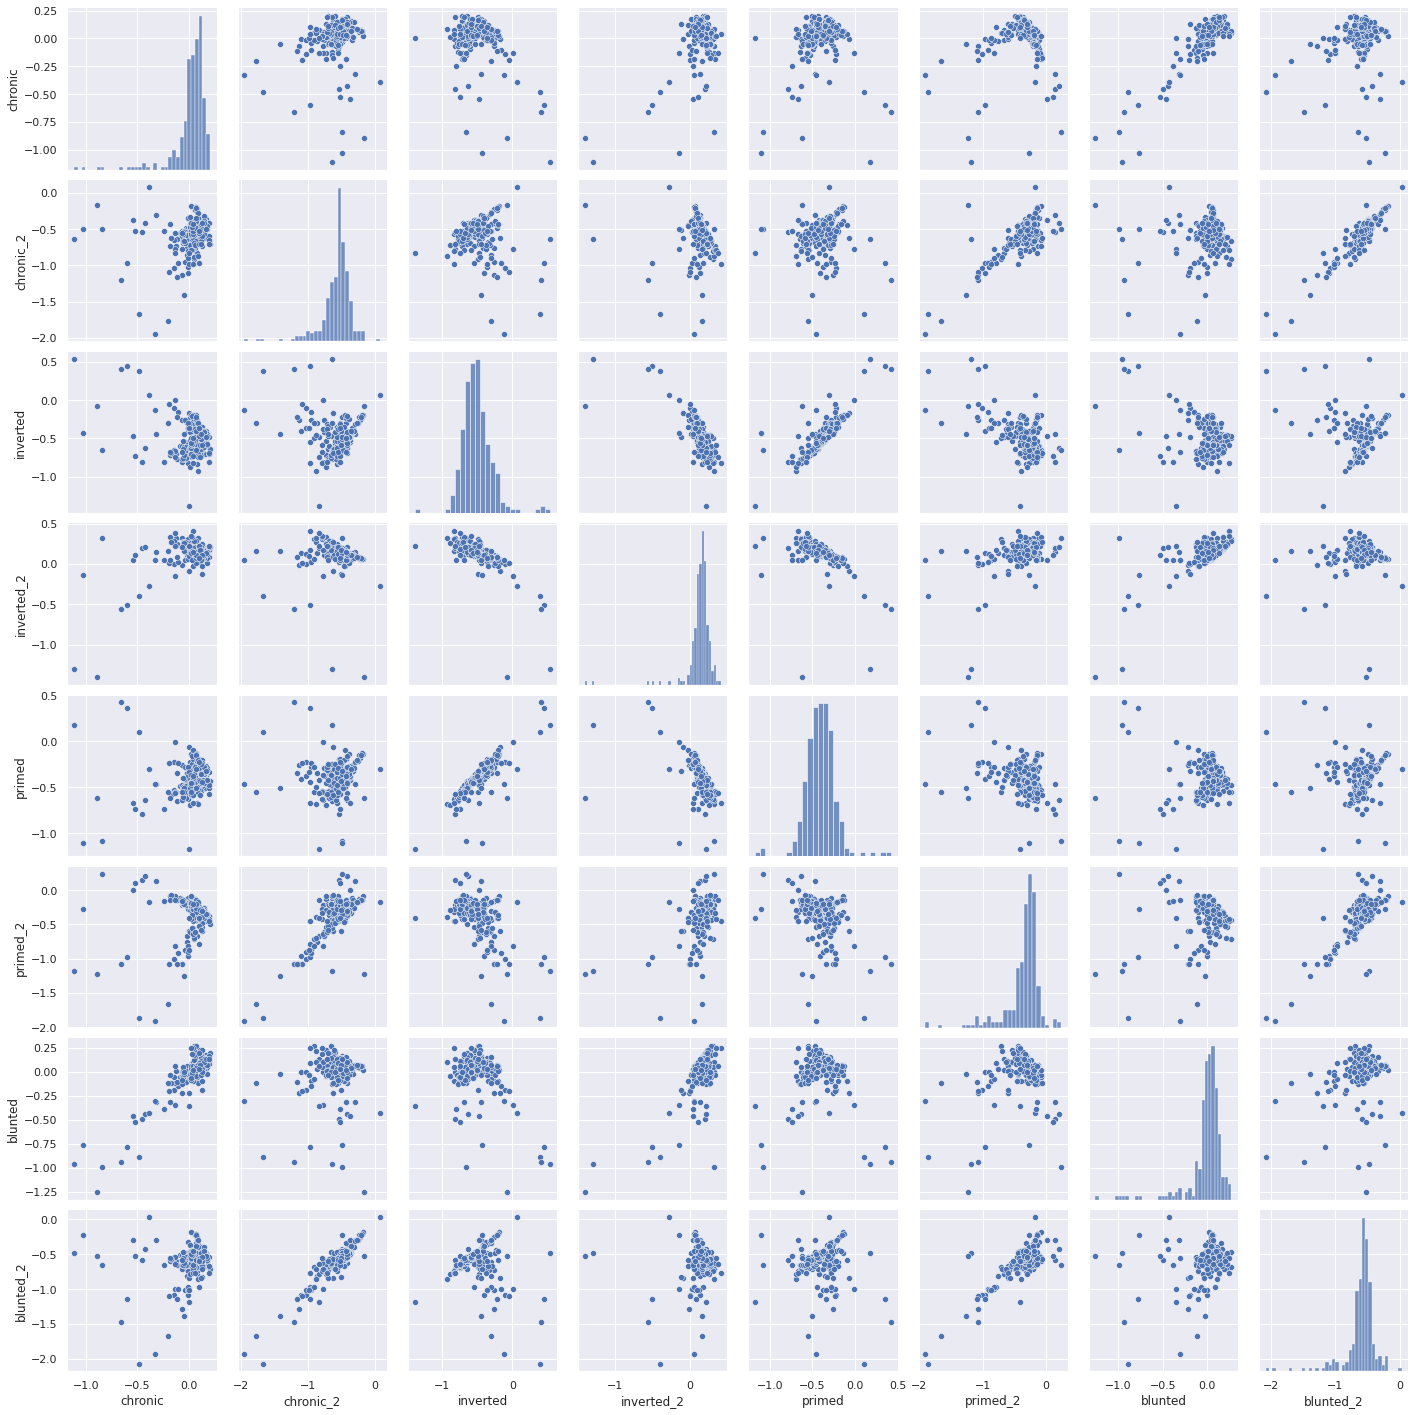

In [18]:
sns.pairplot(res.loc[res.clust=='Oligodendrocytes', ['chronic', 'chronic_2', 'inverted', 'inverted_2', 'primed', 'primed_2', 'blunted', 'blunted_2']])

In [19]:
res[res.clust=='CA1 Glut 1'].sort_values(by='blunted', ascending=False)

gene       clust  BL_Ctrl_expr  BL_Stress_expr  ELS_Ctrl_expr  \
4729    Cwc22  CA1 Glut 1      0.315737        1.000000       0.364650   
4674    Pdia6  CA1 Glut 1      0.597402        1.000000       0.705896   
5015     Rfng  CA1 Glut 1      0.643275        1.000000       0.807731   
4693     Glo1  CA1 Glut 1      0.519358        1.000000       0.642198   
4599     Cds1  CA1 Glut 1      0.720024        1.000000       0.733203   
...       ...         ...           ...             ...            ...   
4768   Rnf115  CA1 Glut 1      0.546625        0.828450       0.641222   
4927      Mt1  CA1 Glut 1      0.496040        0.705295       0.666653   
4987    Gstp1  CA1 Glut 1      1.000000        0.769329       0.769492   
5008     Nnat  CA1 Glut 1      0.623321        0.544506       1.000000   
4950  Gm47283  CA1 Glut 1      0.662567        0.345324       1.000000   

      ELS_Stress_expr   chronic  chronic_2  inverted  inverted_2    primed  \
4729         0.449223  0.006626  -1.361900 -0.648603    0.550777 -0.892909   
4674         0.729861  0.096511  -0.708684 -0.487127    0.270139 -0.471438   
5015         0.801992  0.155847  -0.557603 -0.526921    0.198008 -0.376371   
4693         0.757806  0.065035  -0.896249 -0.487873    0.242194 -0.482515   
4599         0.788540 -0.014489  -0.574441 -0.237818    0.211460 -0.351448   
...               ...       ...        ...       ...         ...       ...   
4768         1.000000 -0.084793  -0.648442 -0.017643   -0.171550  0.030638   
4927         1.000000 -0.252124  -0.670633 -0.046520   -0.294705  0.058108   
4987         0.988307 -0.559056  -0.097714  0.218978   -0.679994 -0.127029   
5008         0.691360 -0.688629  -0.530998 -0.606503   -0.146854 -0.803541   
4950         0.555069 -1.194385  -0.559899 -0.465122   -0.209745 -1.258229   

      primed_2   blunted  blunted_2  
4729 -1.062055  0.508490  -0.860036  
4674 -0.519368  0.258157  -0.547038  
5015 -0.364892  0.189399  -0.524051  
4693 -0.713732  0.184389  -0.776895  
4599 -0.462121  0.183792  -0.376159  
...        ...       ...        ...  
4768 -0.686919 -0.350939  -0.914589  
4927 -0.608587 -0.461379  -0.879888  
4987 -0.564658 -0.570586  -0.109244  
5008 -0.186262 -0.609814  -0.452183  
4950 -0.368367 -0.877142  -0.242656  

[603 rows x 14 columns]

In [20]:
def plot_scorers(res, clust, save=False):
    res_clust = res[res.clust == clust]

    fig, ax = plt.subplots(4, 2, figsize=(10, 20), sharex=True)

    sc.pl.violin(
        adata_[adata_.obs.louvain == clust],
        groupby='condition',
        keys=res_clust.sort_values(by='chronic', ascending=False)['gene'].values[0],
        show=False,
        ax=ax[0, 0]
    )
    #ax[0, 0].set_xlabel(res_clust.sort_values(by='chronic', ascending=False)['gene'].values[0])
    ax[0, 0].set_title('Chronic')

    sc.pl.violin(
        adata_[adata_.obs.louvain == clust],
        groupby='condition',
        keys=res_clust.sort_values(by='chronic_2', ascending=False)['gene'].values[0],
        show=False,
        ax=ax[0, 1]
    )
    #ax[0, 1].set_xlabel(res_clust.sort_values(by='chronic_2', ascending=False)['gene'].values[0])
    ax[0, 1].set_title('Chronic_2')

    sc.pl.violin(
        adata_[adata_.obs.louvain == clust],
        groupby='condition',
        keys=res_clust.sort_values(by='inverted', ascending=False)['gene'].values[0],
        show=False,
        ax=ax[1, 0]
    )
    #ax[1, 0].set_xlabel(res_clust.sort_values(by='inverted', ascending=False)['gene'].values[0])
    ax[1, 0].set_title('inverted')

    sc.pl.violin(
        adata_[adata_.obs.louvain == clust],
        groupby='condition',
        keys=res_clust.sort_values(by='inverted_2', ascending=False)['gene'].values[0],
        show=False,
        ax=ax[1, 1]
    )
    #ax[1, 1].set_xlabel(res_clust.sort_values(by='inverted_2', ascending=False)['gene'].values[0])
    ax[1, 1].set_title('inverted_2')

    sc.pl.violin(
        adata_[adata_.obs.louvain == clust],
        groupby='condition',
        keys=res_clust.sort_values(by='primed', ascending=False)['gene'].values[0],
        show=False,
        ax=ax[2, 0]
    )
    ax[2, 0].set_title('primed')
    #ax[2, 0].set_xlabel(res_clust.sort_values(by='primed', ascending=False)['gene'].values[0])

    sc.pl.violin(
        adata_[adata_.obs.louvain == clust],
        groupby='condition',
        keys=res_clust.sort_values(by='primed_2', ascending=False)['gene'].values[0],
        show=False,
        ax=ax[2, 1]
    )
    ax[2, 1].set_title('primed_2')
    #ax[2, 1].set_xlabel(res_clust.sort_values(by='primed_2', ascending=False)['gene'].values[0])

    sc.pl.violin(
        adata_[adata_.obs.louvain == clust],
        groupby='condition',
        keys=res_clust.sort_values(by='blunted', ascending=False)['gene'].values[0],
        show=False,
        ax=ax[3, 0]
    )
    ax[3, 0].set_title('blunted')
    #ax[3, 1].set_xlabel(res_clust.sort_values(by='blunted', ascending=False)['gene'].values[0])

    sc.pl.violin(
        adata_[adata_.obs.louvain == clust],
        groupby='condition',
        keys=res_clust.sort_values(by='blunted_2', ascending=False)['gene'].values[0],
        show=False,
        ax=ax[3, 1]
    )
    ax[3, 1].set_title('blunted_2')
    #ax[3, 1].set_xlabel(res_clust.sort_values(by='blunted_2', ascending=False)['gene'].values[0])

    for ax in ax.flatten():
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    fig.tight_layout(rect=[0, 0.3, 1, 0.95])
    fig.suptitle(clust)
    if save:
        fig.savefig('./figures/scorers_' + clust + '.png', dpi=500)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attrib

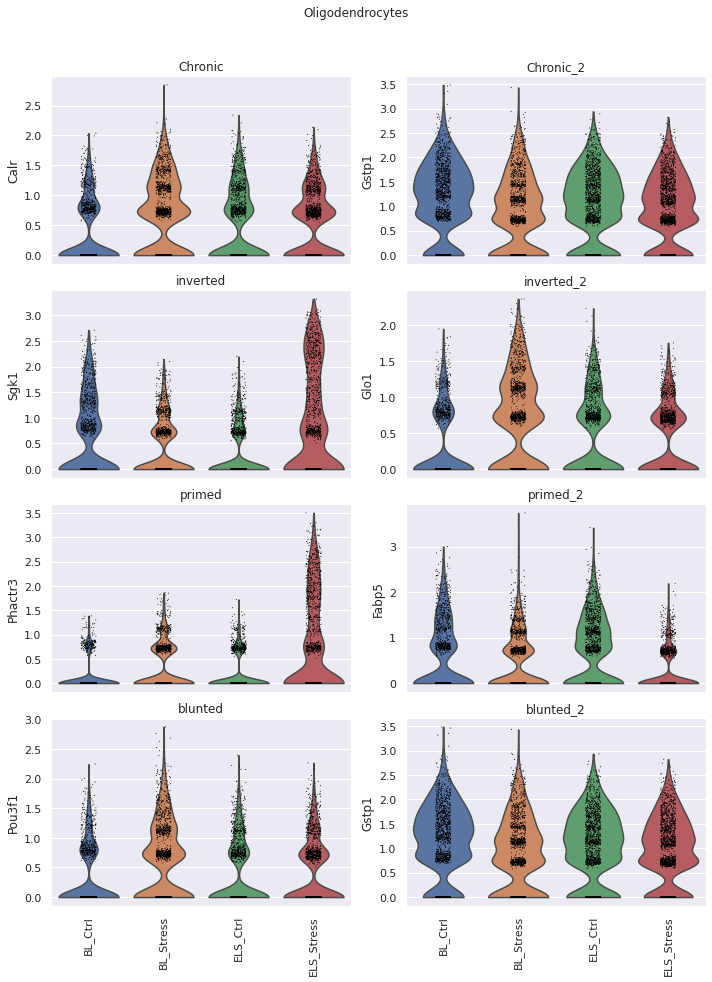

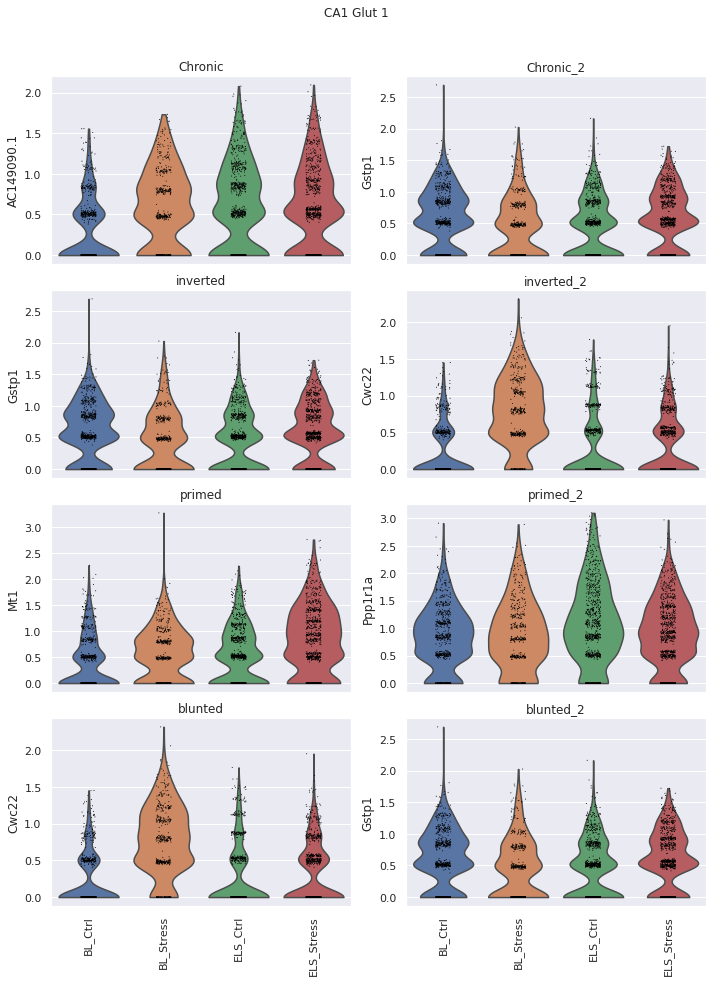

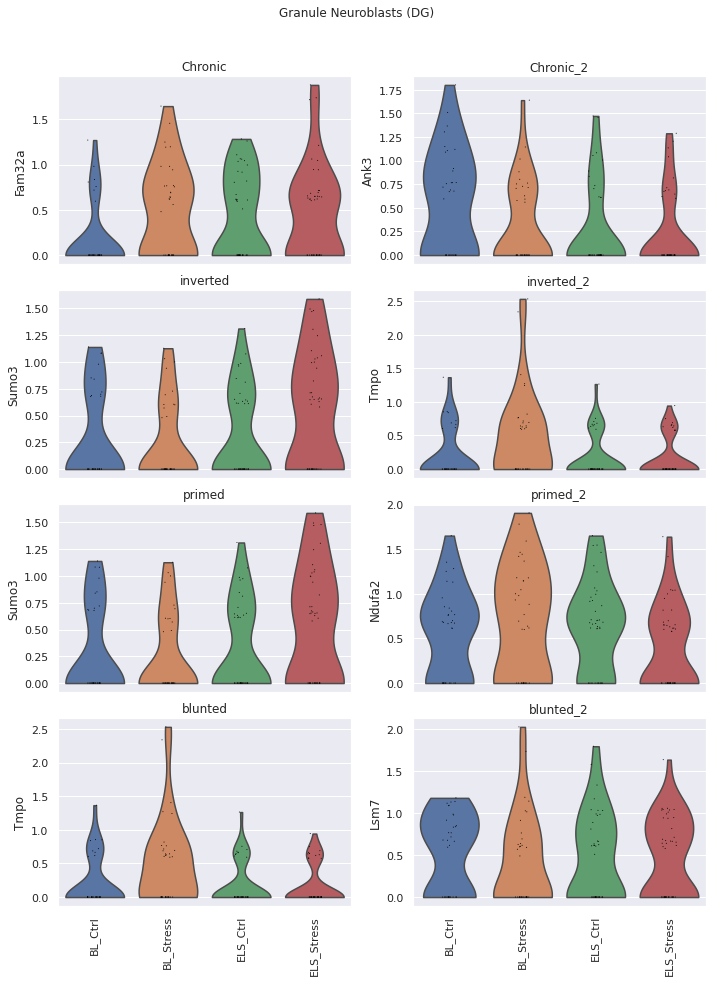

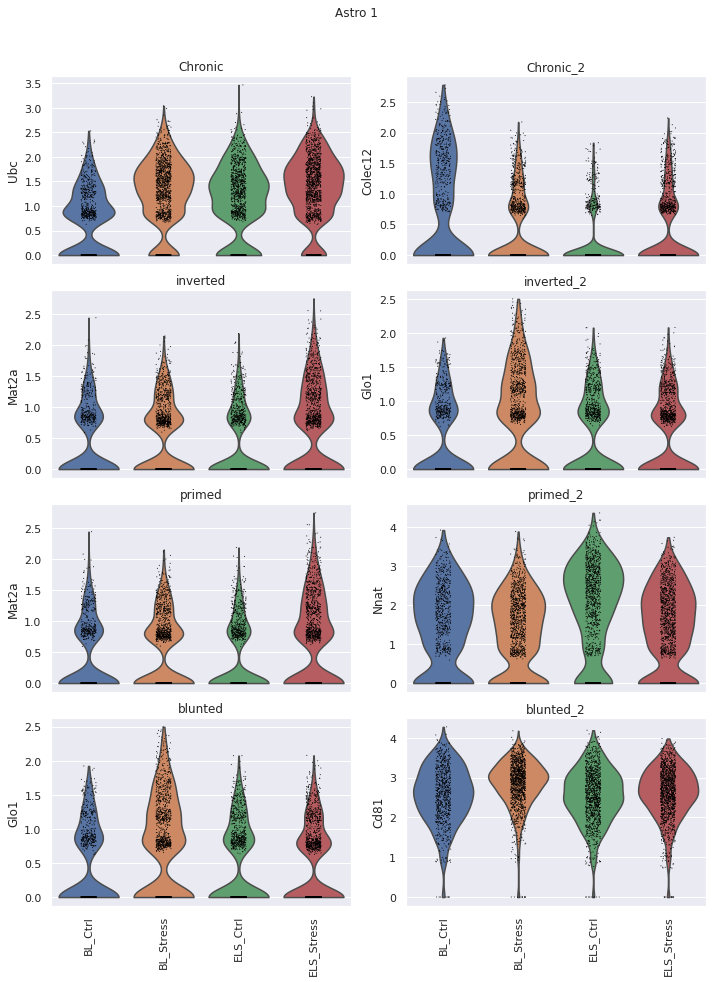

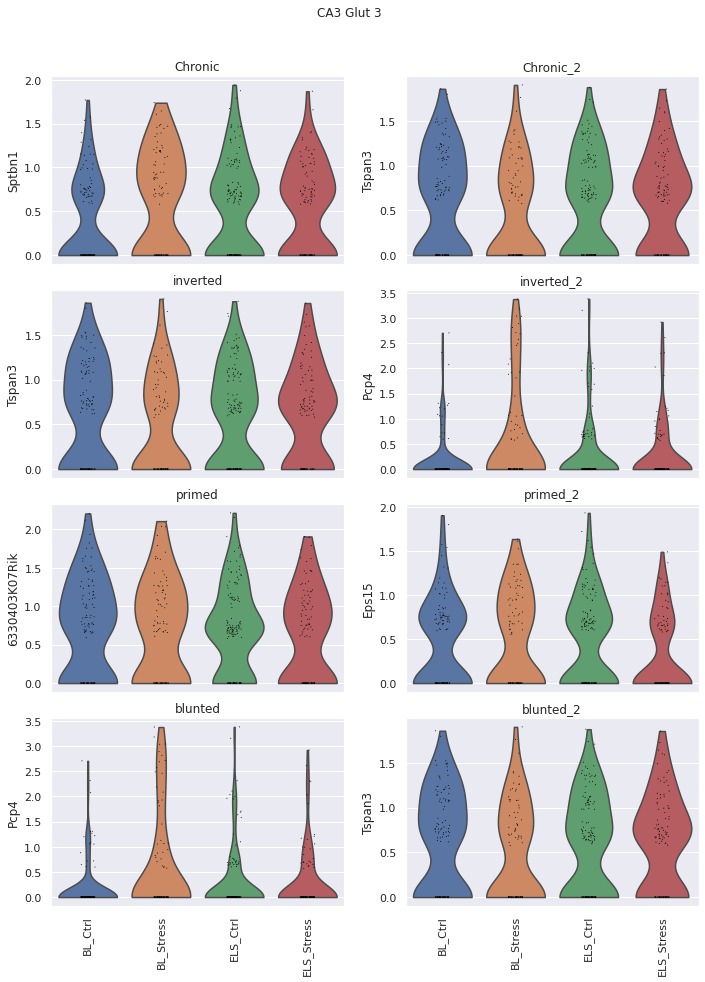

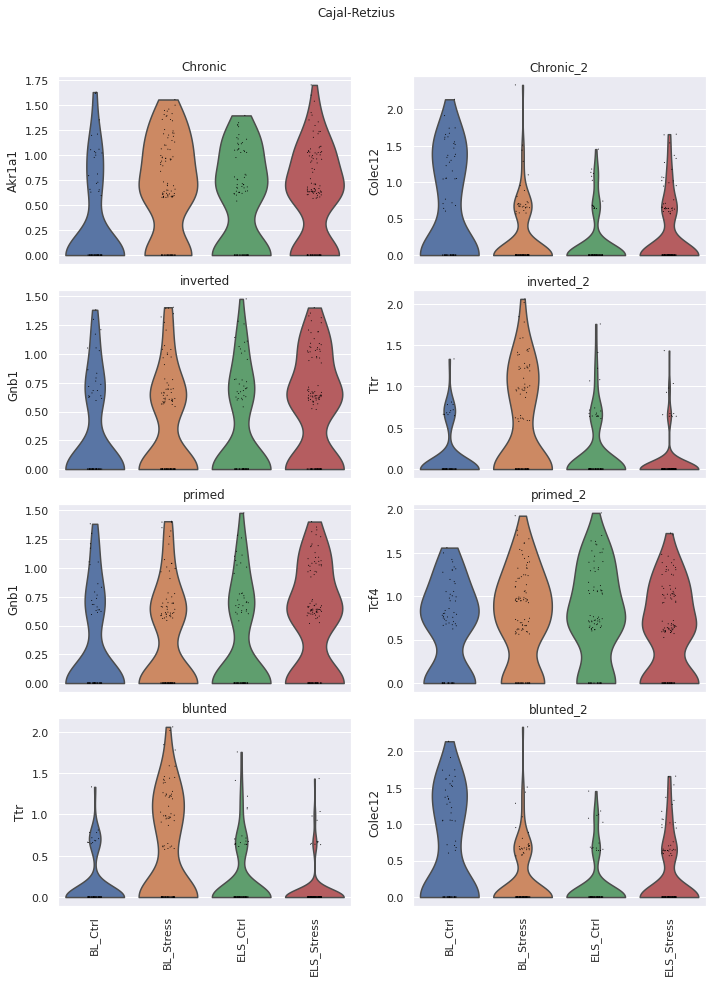

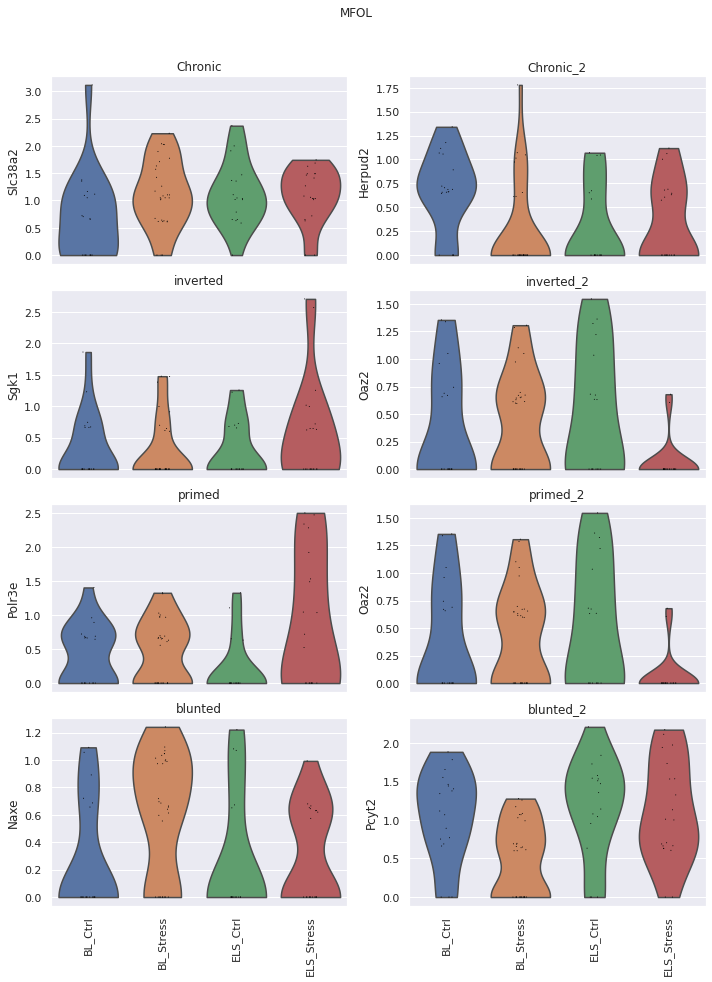

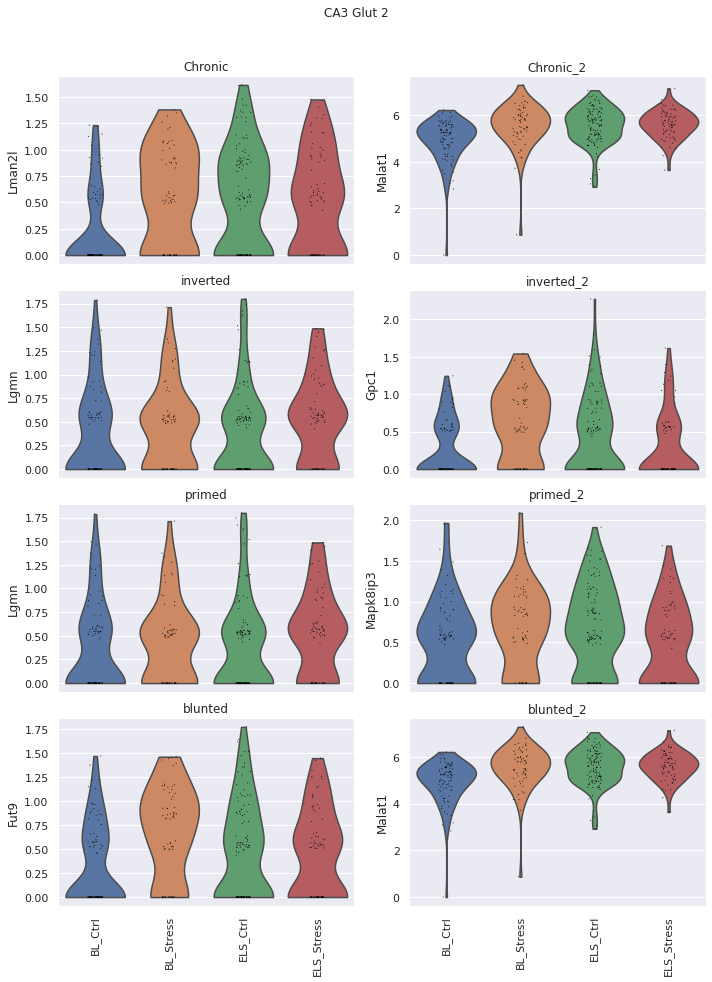

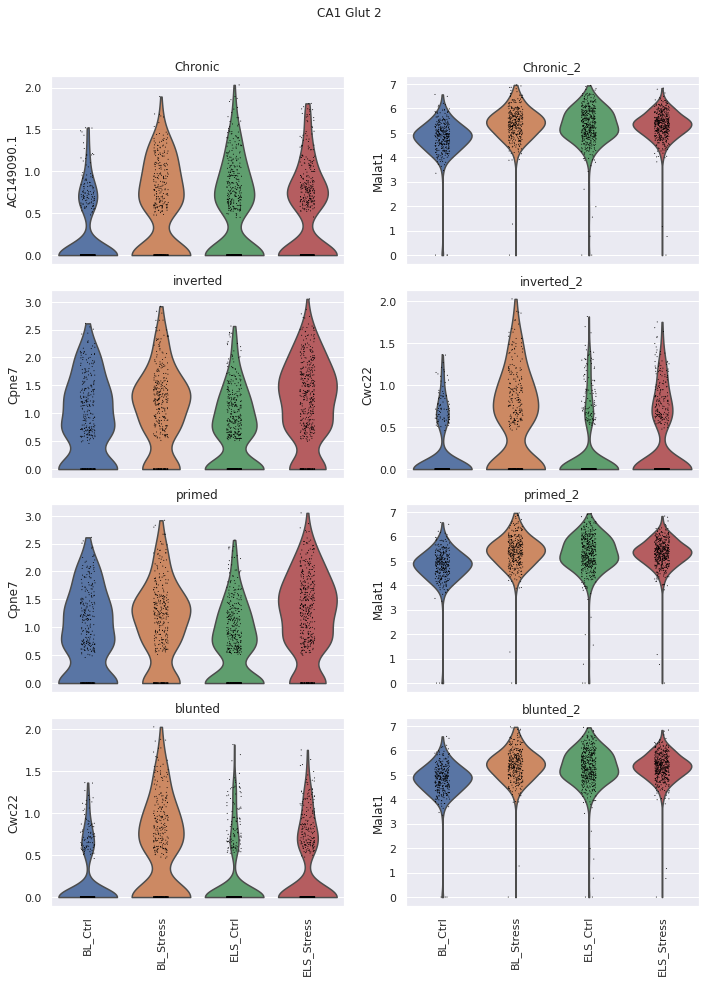

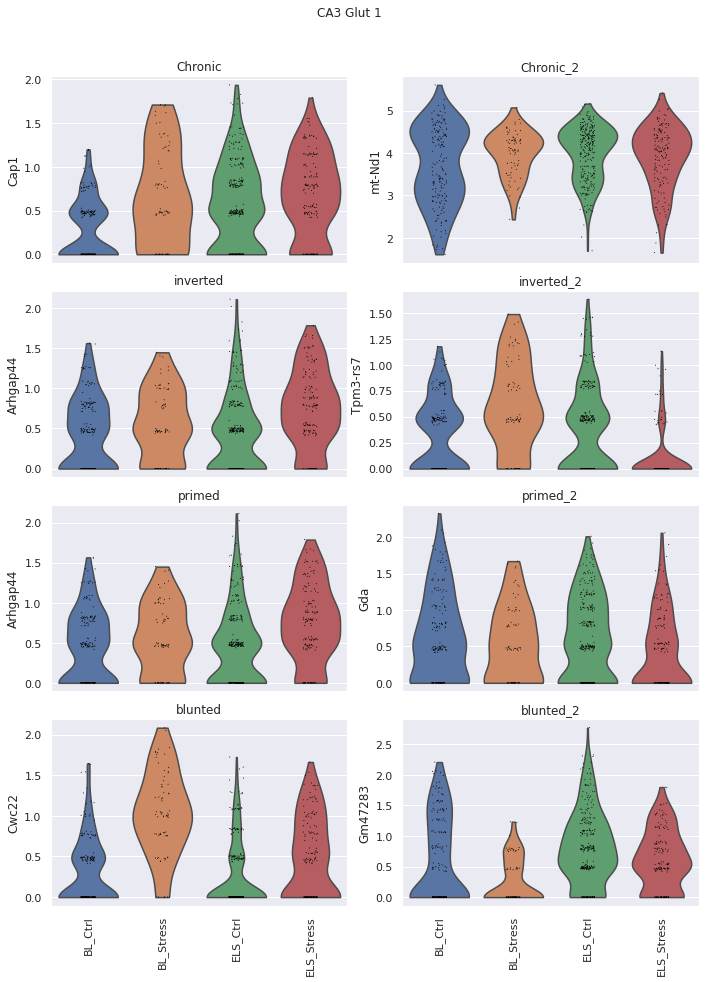

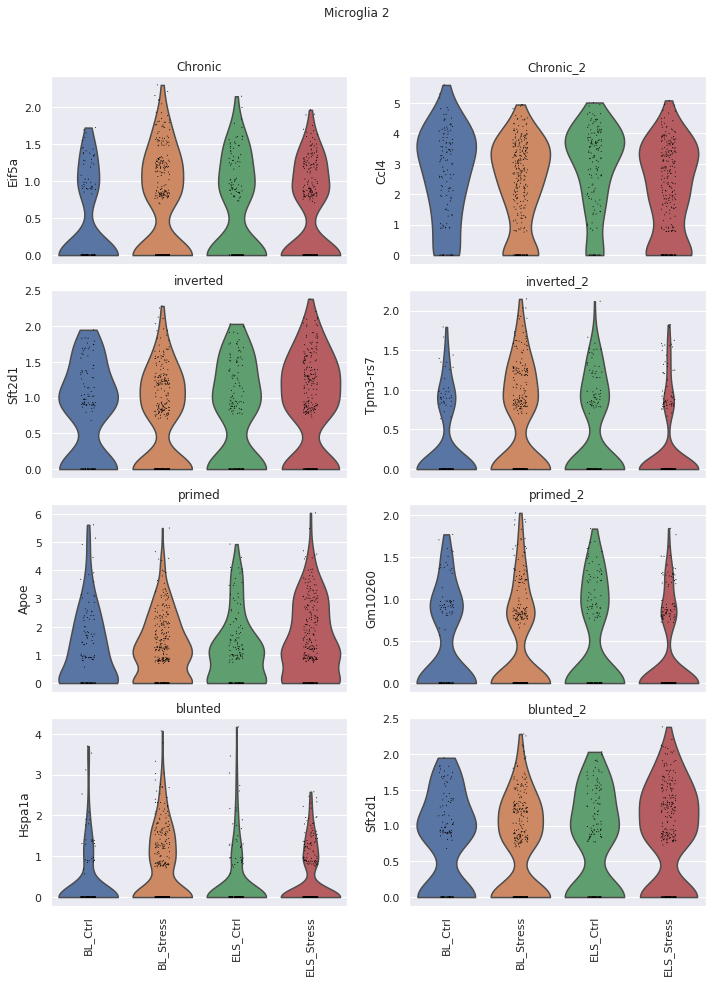

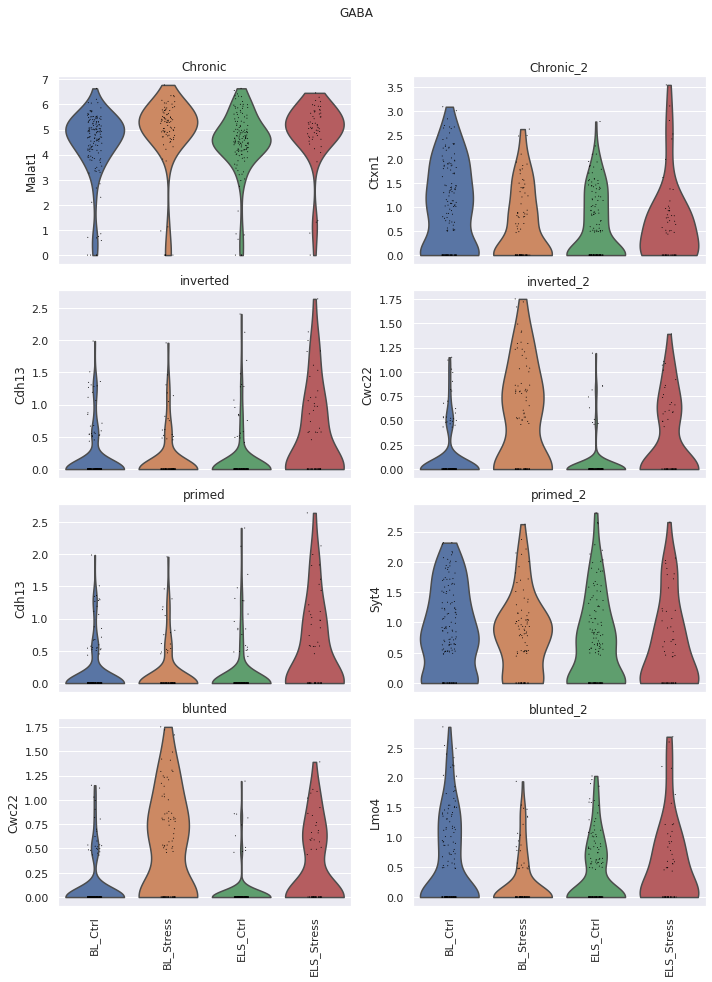

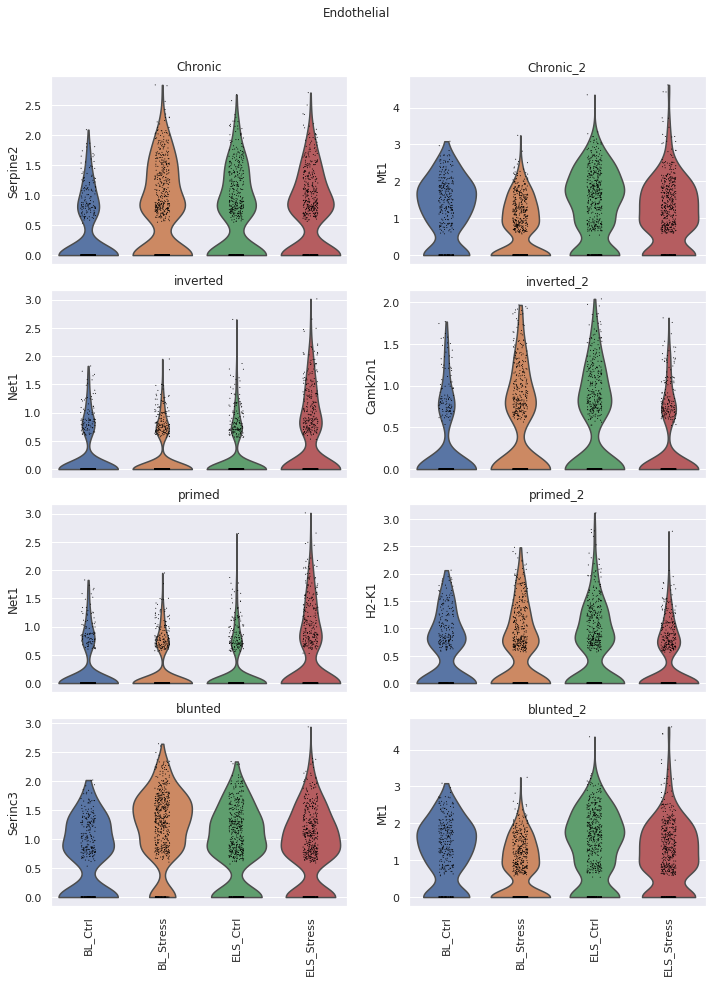

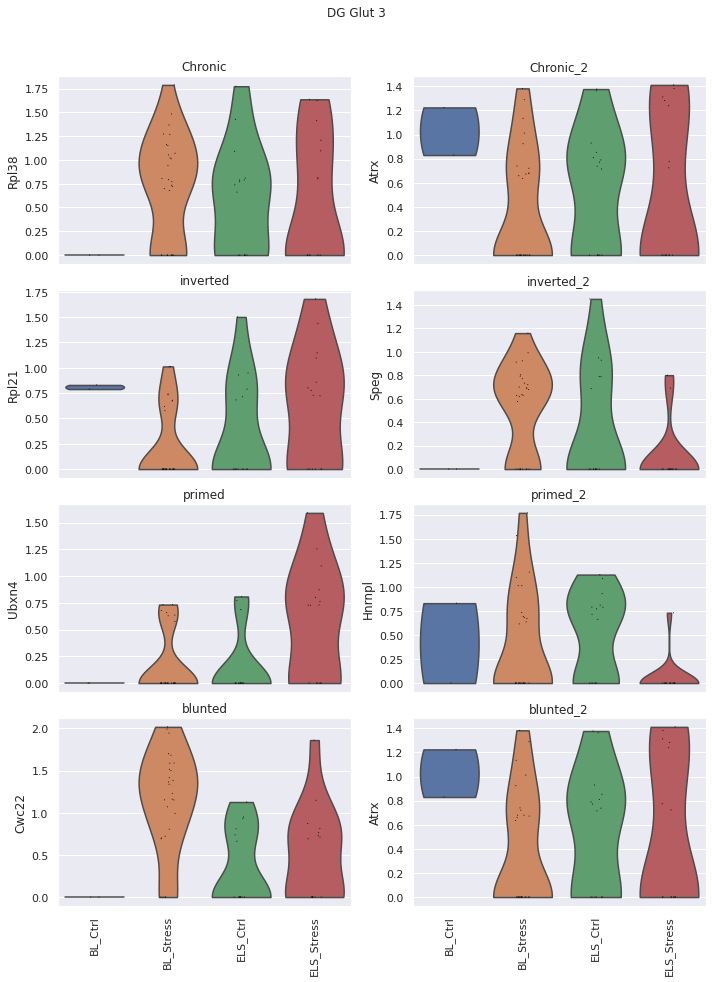

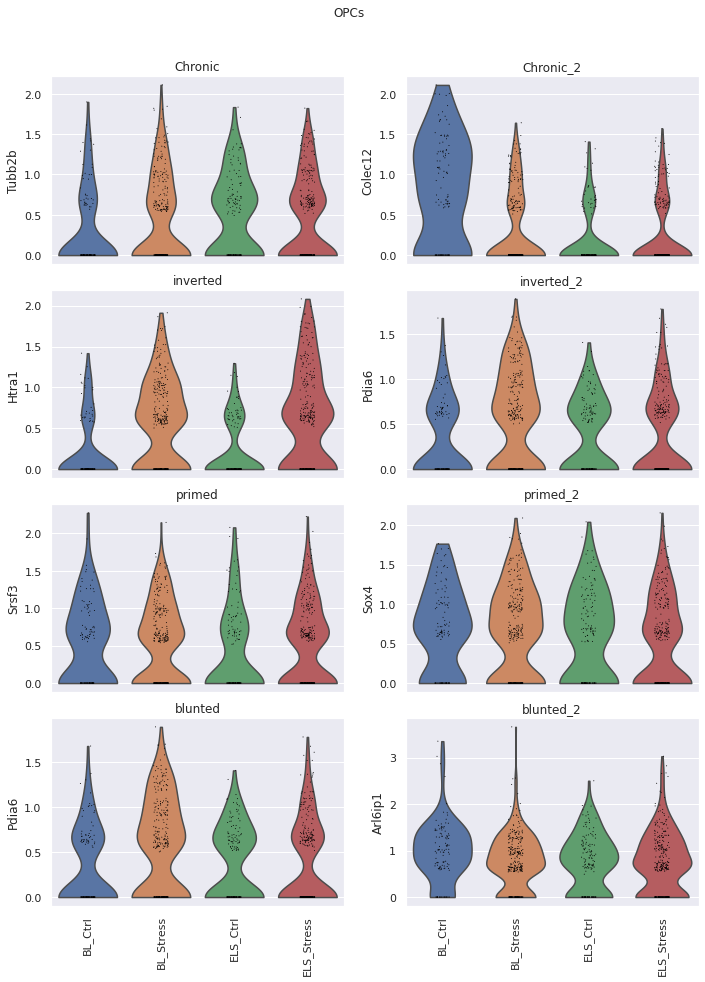

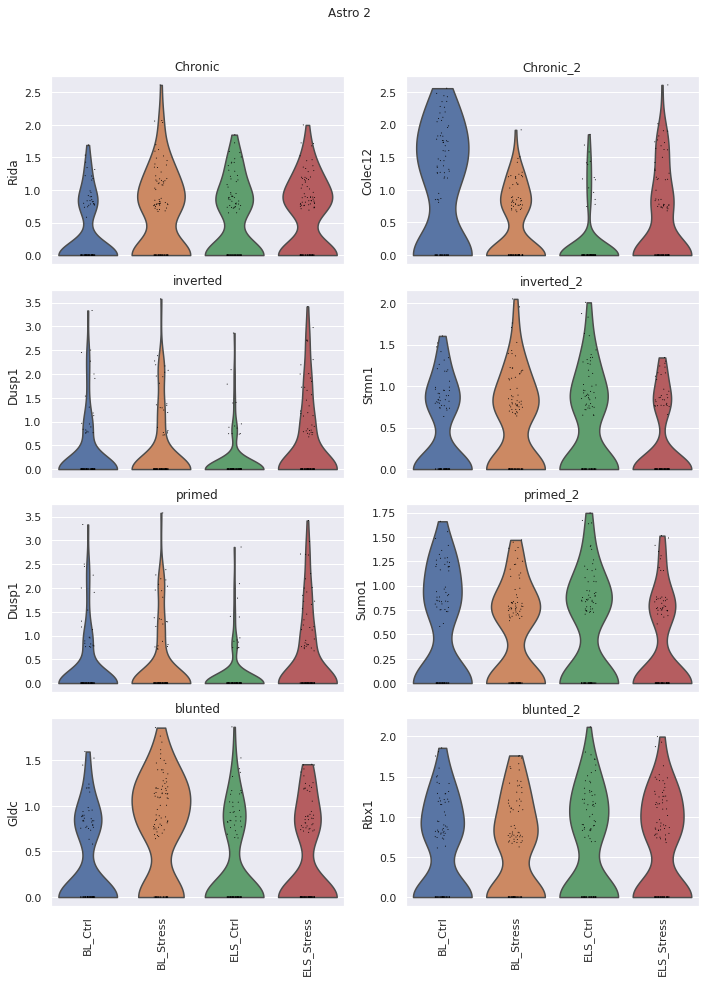

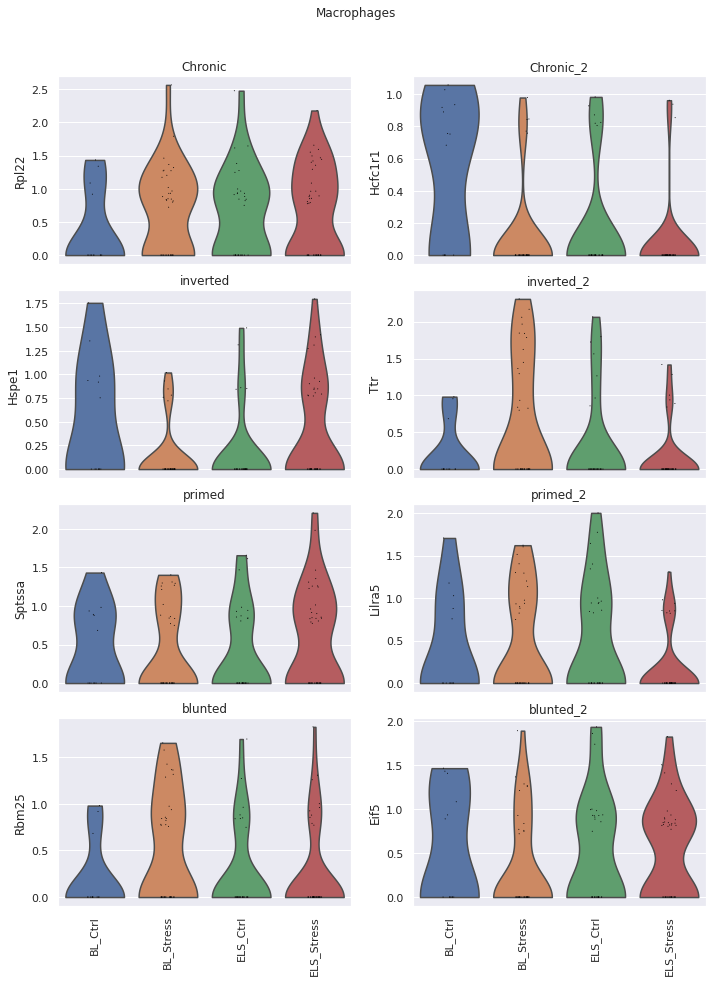

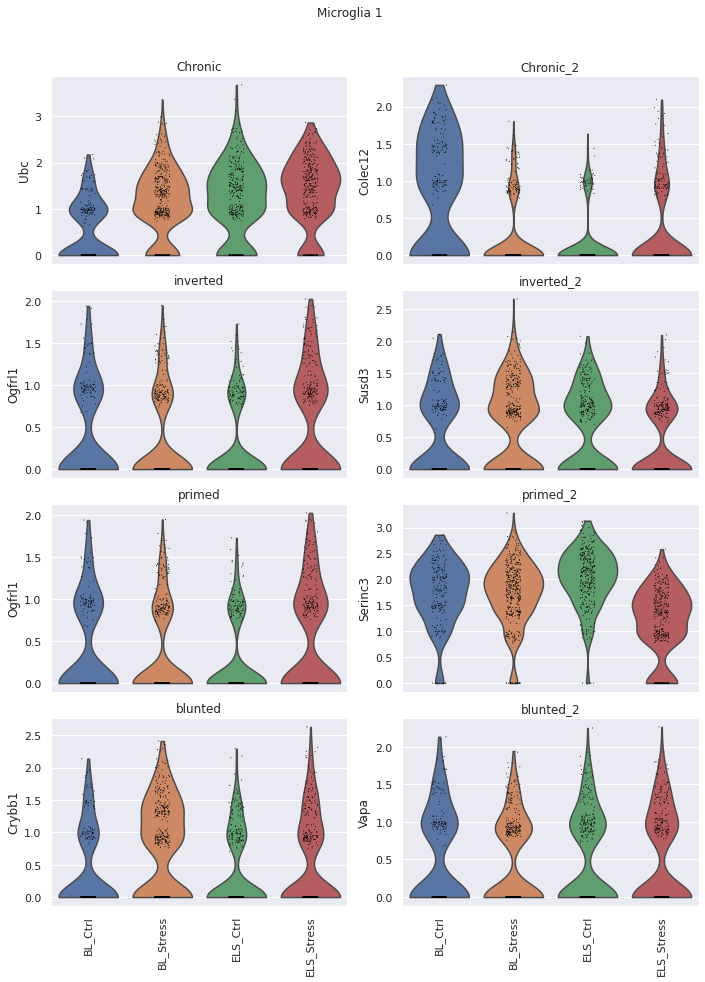

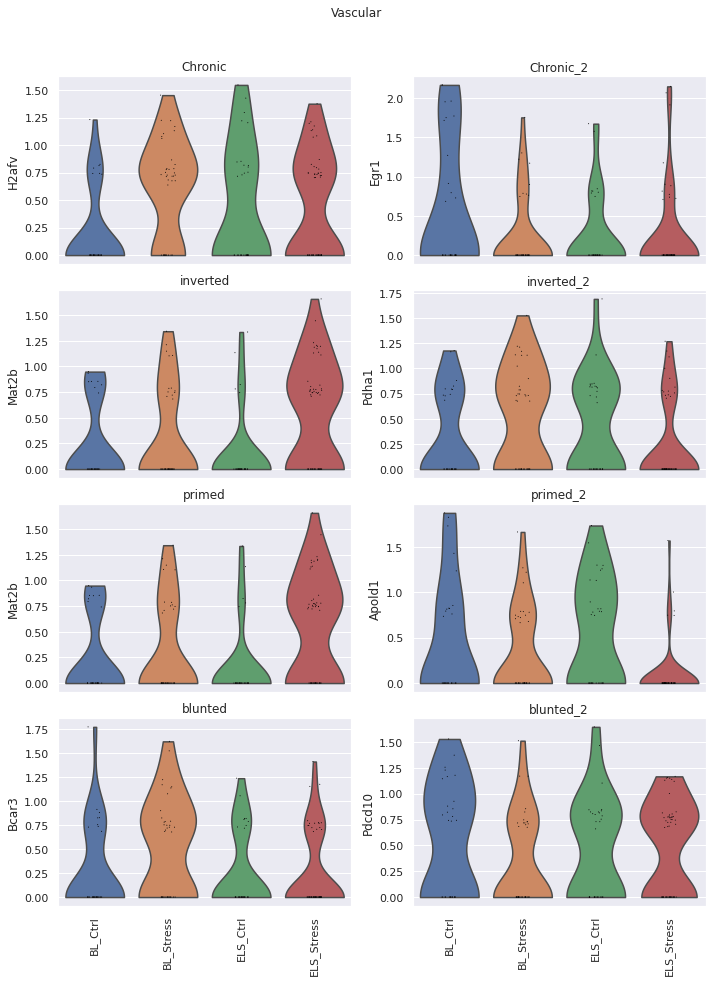

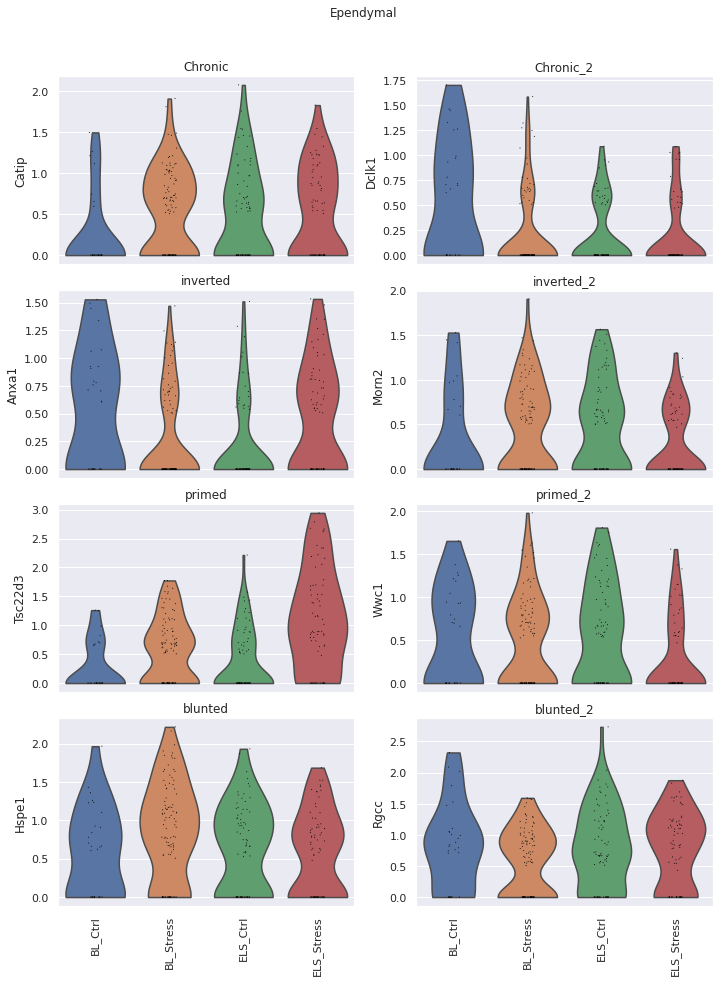

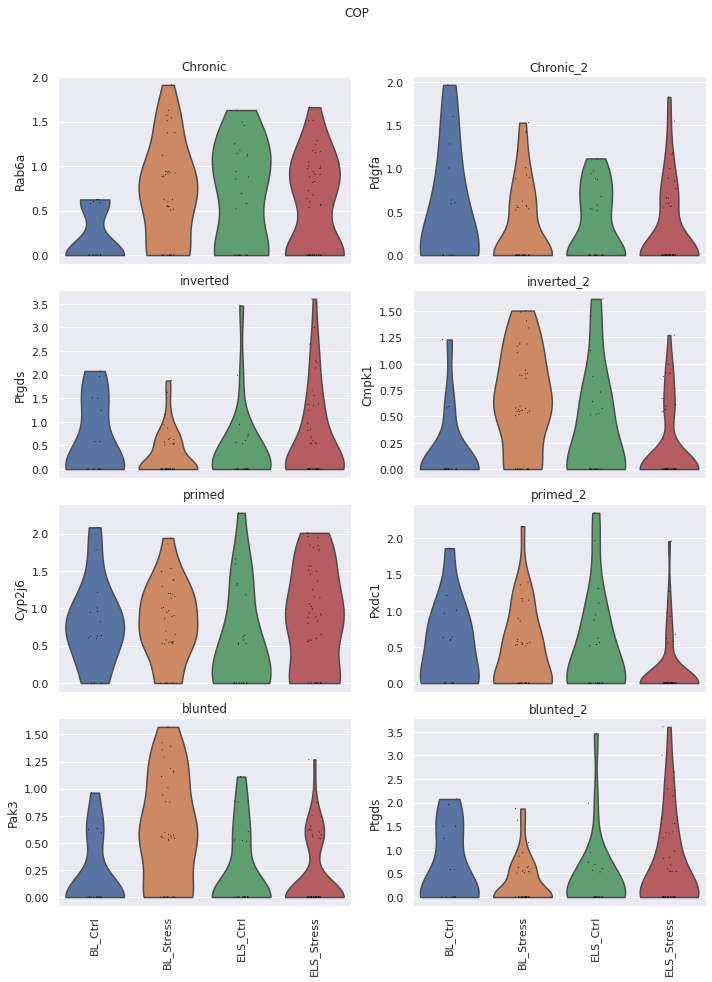

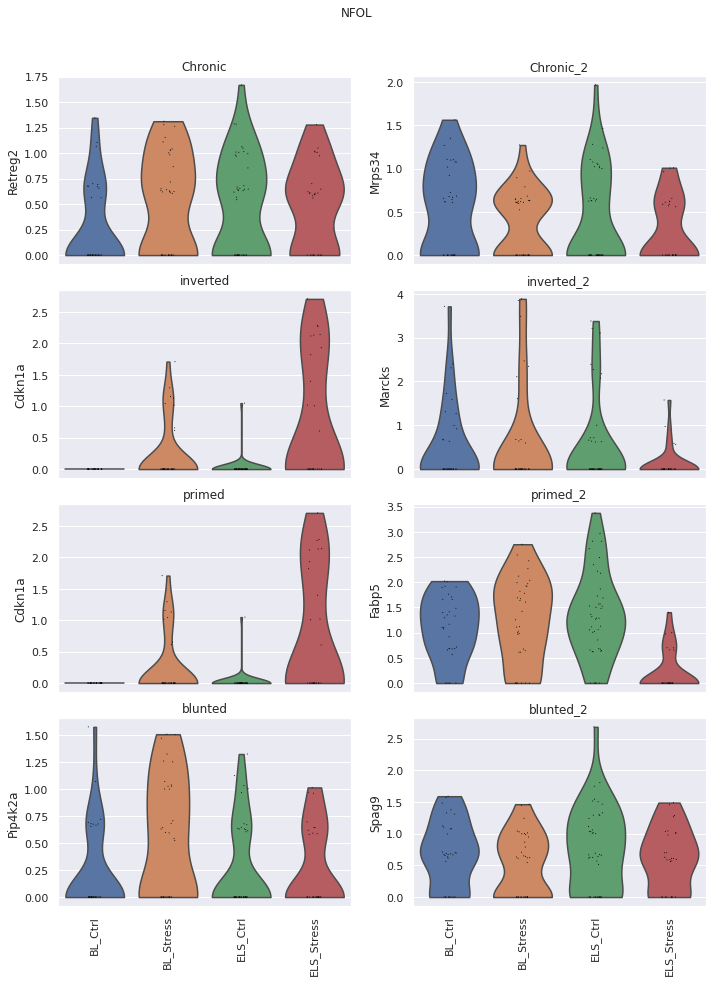

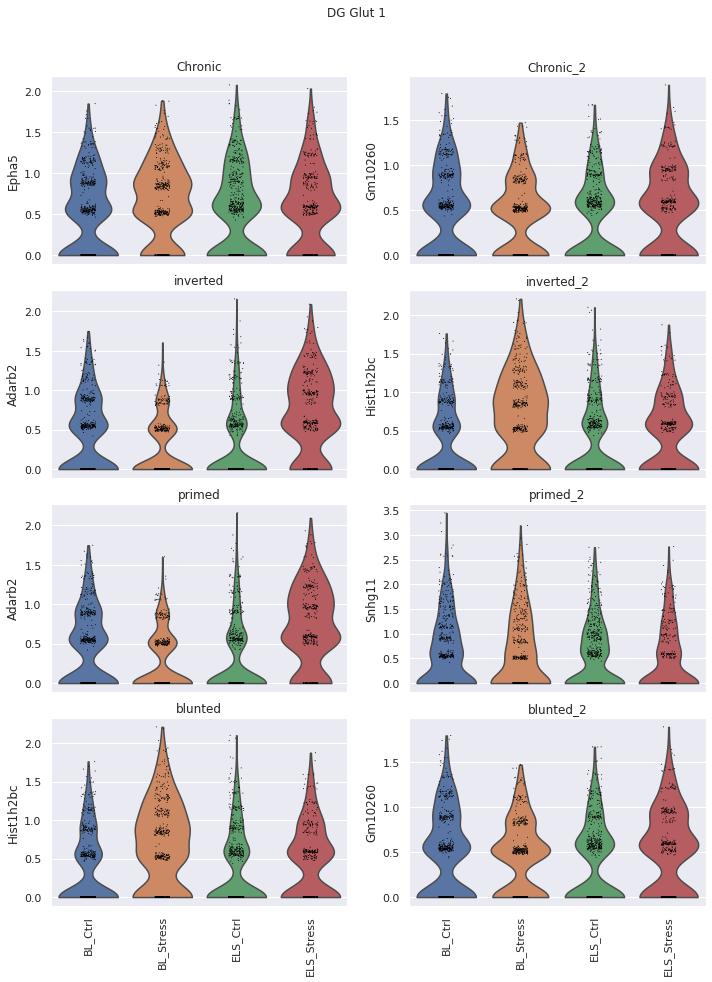

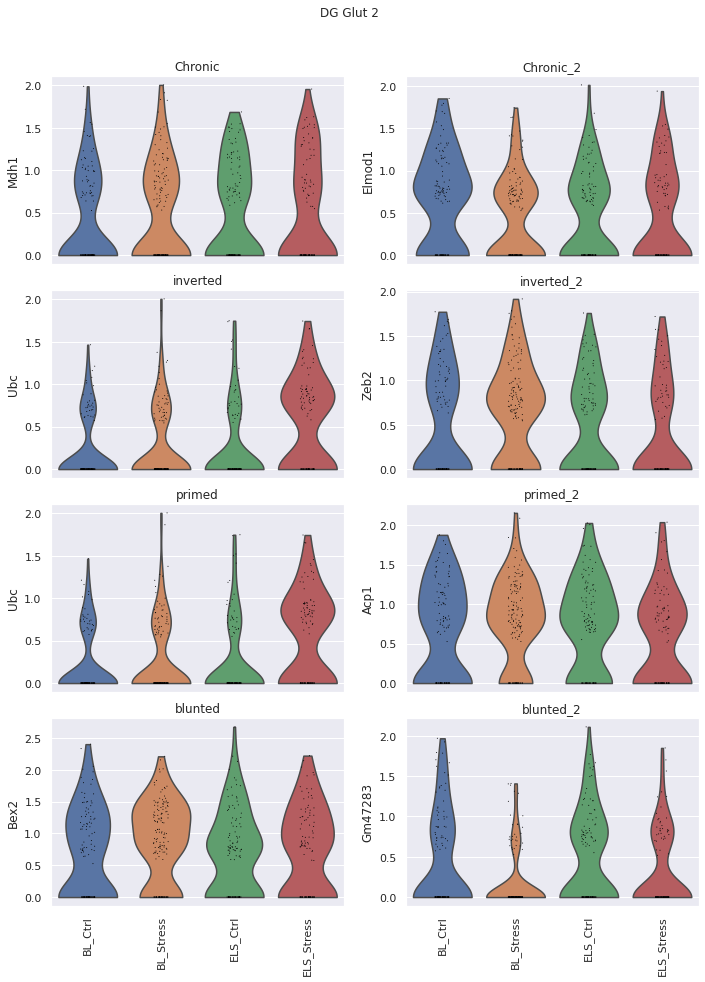

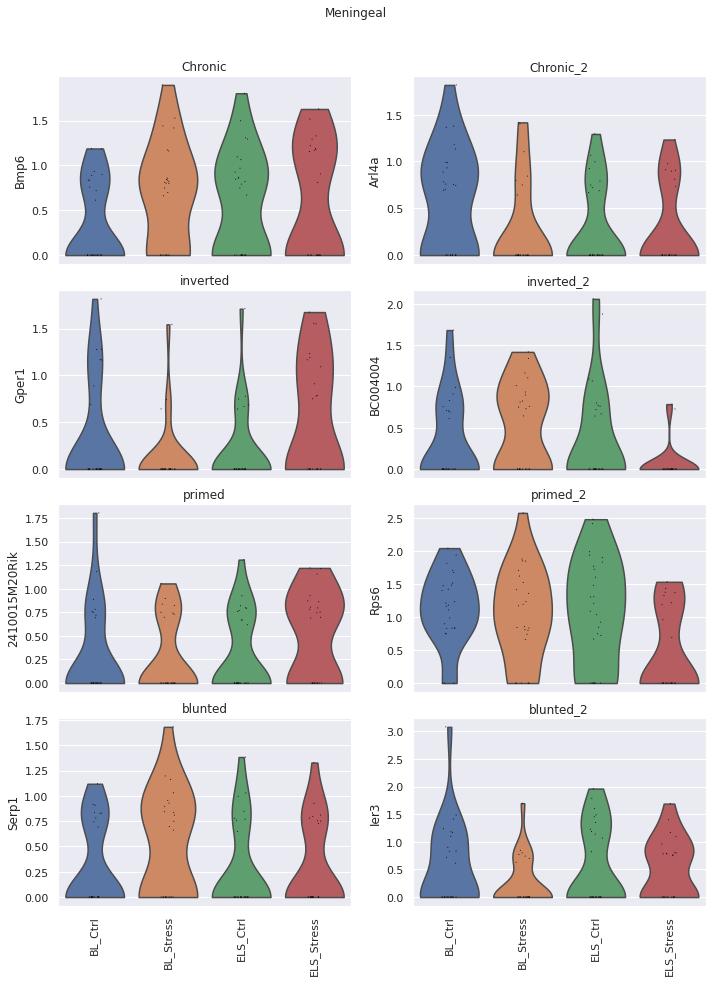

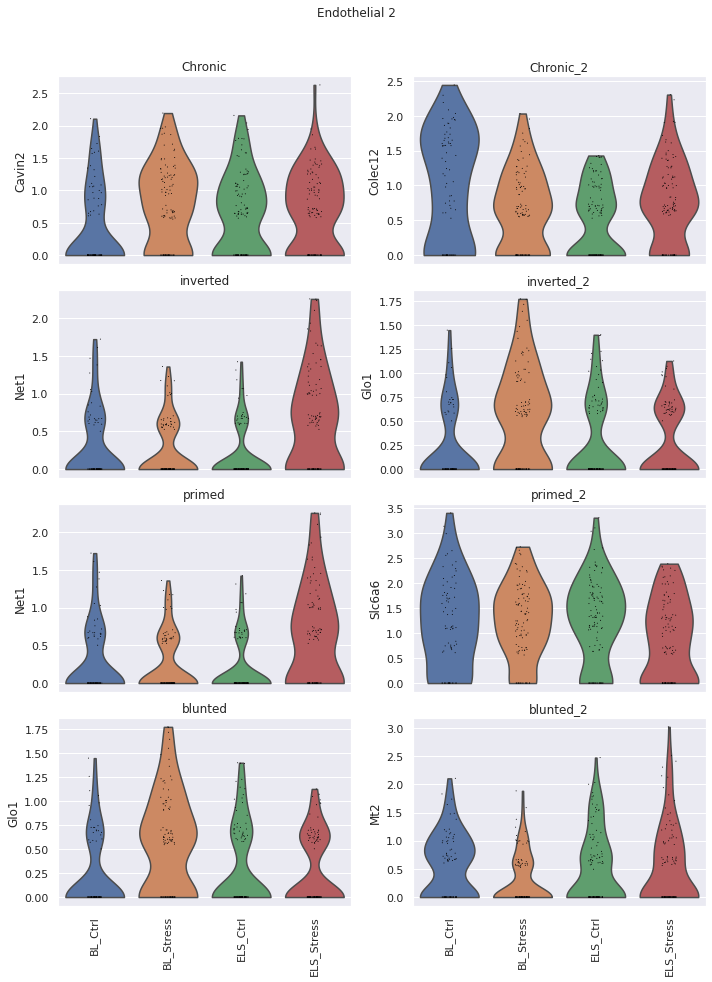

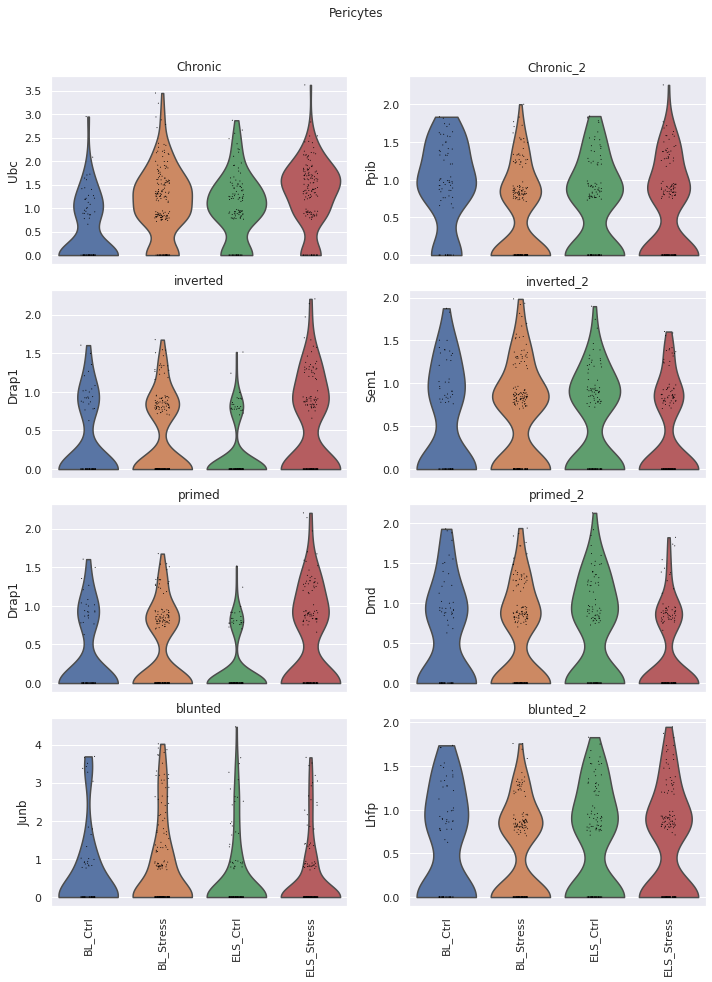

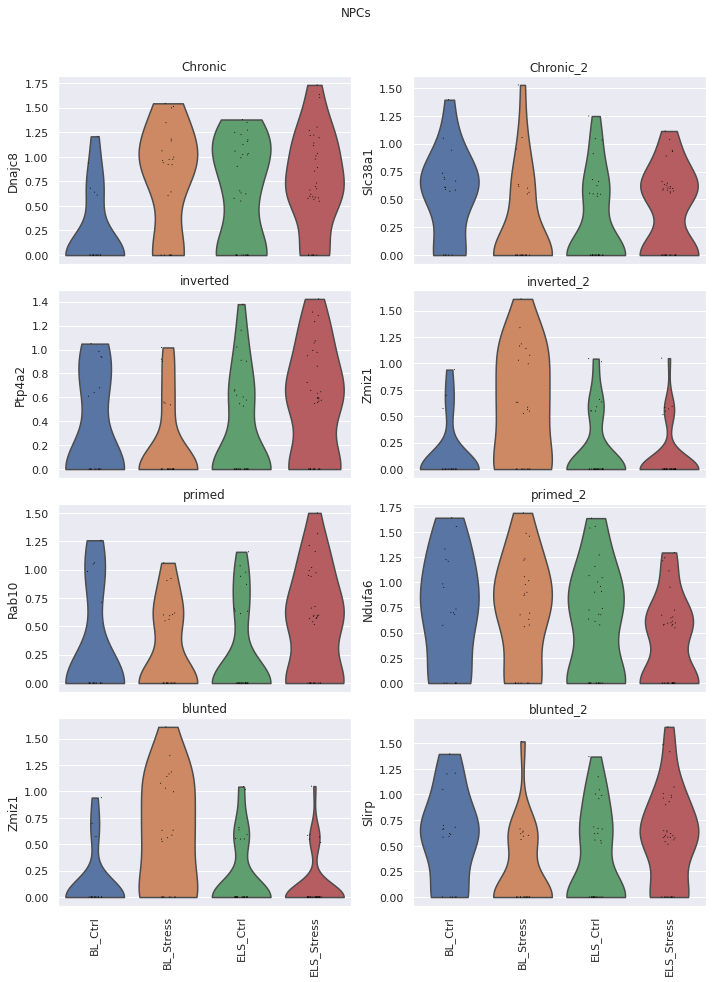

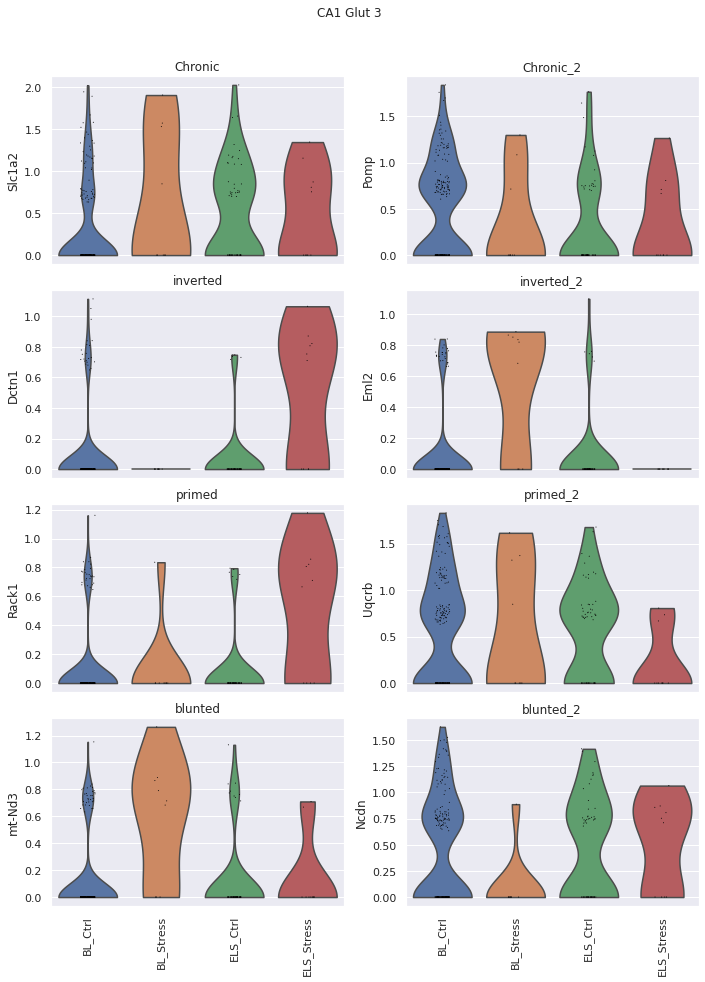

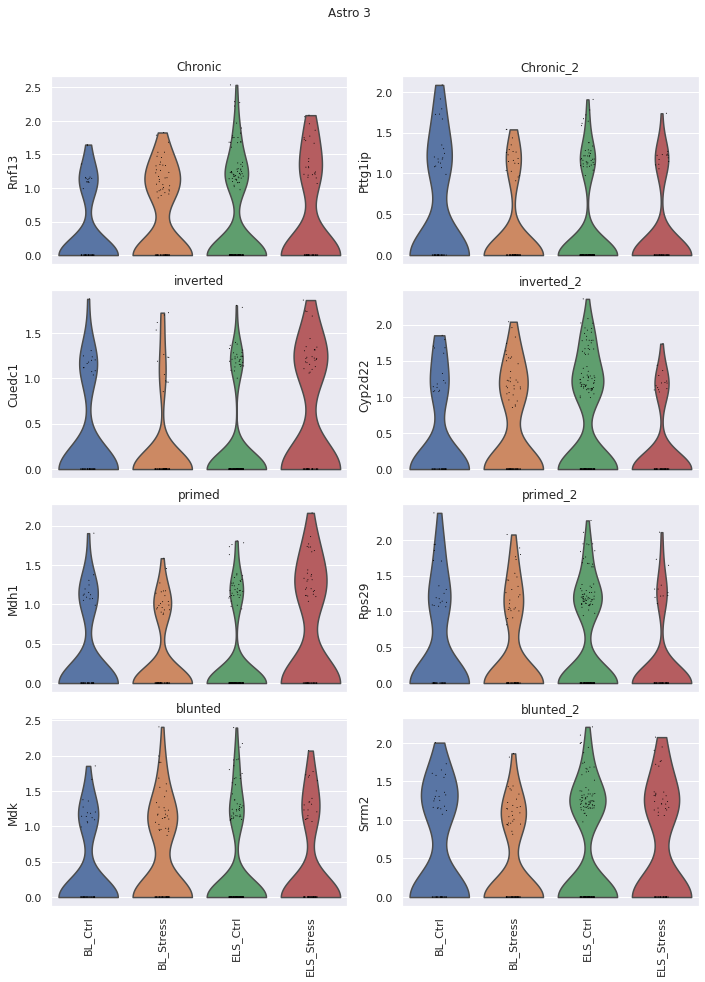

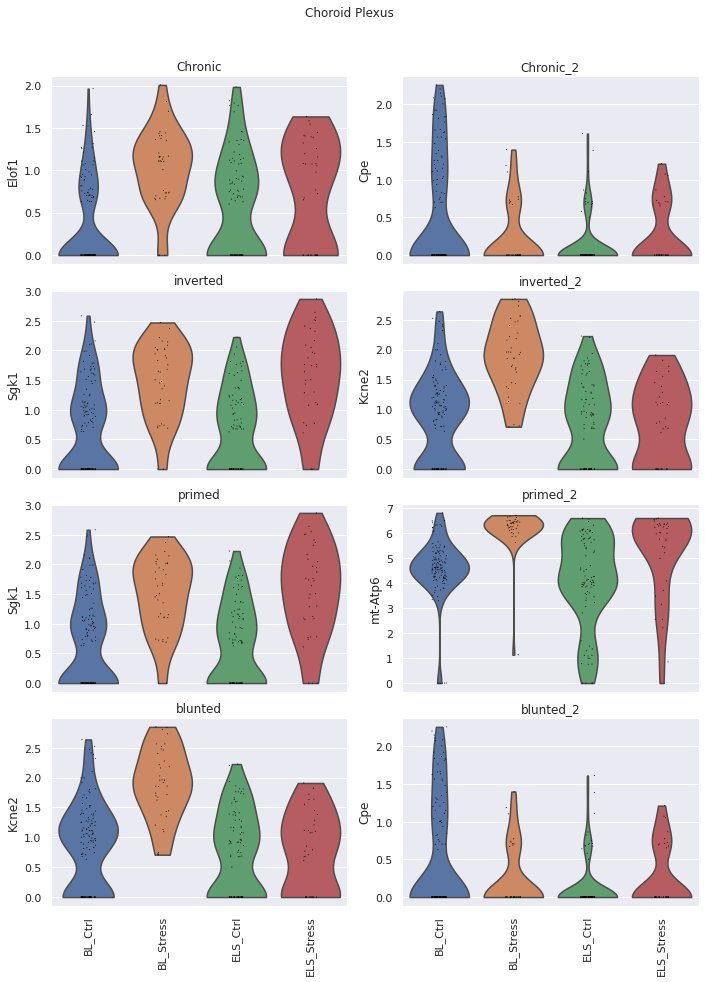

In [21]:
for clust in adata.obs.louvain.unique():
    plot_scorers(res, clust, save=True)

In [22]:
writer = pd.ExcelWriter('pattern_scores.xlsx', engine='xlsxwriter')
for clust in res.clust.unique():
    res_clust = res[res.clust == clust]
    res_clust.to_excel(writer,sheet_name=str(clust))
writer.save()